In [1]:
# (a) (4 points) Plot for VGG11, VGG11 with batch normalization, ResNet18,
# ResNet34, DenseNet121 and MobileNet-v3-Small, the Top-1 accuracy on ImageNet
# vs the inference speed. The value for the Top-1 accuracy of each model can be
# found on the PyTorch website. Also plot the inference speed vs the number
# of parameters. Does it scale proportionately? Make sure to set the model on
# evaluation mode, use torch.no_grad() and a GPU. Report the inference
# speed in ms for one image. Average the inference

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torch import nn
import time

vgg11 = models.vgg11(weights="VGG11_Weights.DEFAULT")
vgg11_bn = models.vgg11_bn(weights="VGG11_BN_Weights.DEFAULT")
resnet18 = models.resnet18(weights="ResNet18_Weights.DEFAULT")
resnet34 = models.resnet34(weights="ResNet34_Weights.DEFAULT")
densenet121 = models.densenet121(weights="DenseNet121_Weights.DEFAULT")
mobilenet_v3_small = models.mobilenet_v3_small(weights="MobileNet_V3_Small_Weights.DEFAULT")
model = [(vgg11, "vgg11"), (vgg11_bn, "vgg11_bn"), (resnet18, "resnet18"), (resnet34, "resnet34"), 
        (densenet121, "densenet121"), (mobilenet_v3_small, "mobilenet_v3_small")]

# Info from PyTorch website
top_1_accuracy = [69.02, 70.37, 69.758, 73.314, 74.434, 67.668]
num_parameters = [132863336, 132868840, 11689512, 21797672, 7978856, 2542856]

# set seed
torch.manual_seed(123)


In [41]:
def inference_speed(model, device, k = 100, grad = False):
    model.eval()
    model.to(device)
    total_time = 0.0
    if grad:
        for i in range(10):
            rand_img = torch.rand(1, 3, 224, 224).to(device)
            model(rand_img)
        for i in range(k):
            rand_img = torch.rand(1, 3, 224, 224).to(device)
            start = time.time()
            model(rand_img)
            end = time.time()
            total_time+=end-start
    else:
        with torch.no_grad():
            for i in range(10):
                rand_img = torch.rand(1, 3, 224, 224).to(device)
                model(rand_img)
            for i in range(k):
                rand_img = torch.rand(1, 3, 224, 224).to(device)
                start = time.time()
                model(rand_img)
                end = time.time()
                total_time+=end-start
    
    torch.cuda.empty_cache()
    return total_time/k * 1000 # in ms
    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Device is Geforce 1080 Ti, running on local machine (Ubuntu 20.04)
inference_speeds = [inference_speed(m, device) for m, _ in model]
inference_speeds_grad = [inference_speed(m, device, grad = True) for m, _ in model]

In [42]:
print(inference_speeds)
print(inference_speeds_grad)

[0.8144879341125488, 1.129593849182129, 2.0311903953552246, 3.7137508392333984, 11.664173603057861, 3.8680195808410645]
[0.9242081642150879, 1.1967229843139648, 2.3143649101257324, 4.0425848960876465, 13.321795463562012, 4.533848762512207]


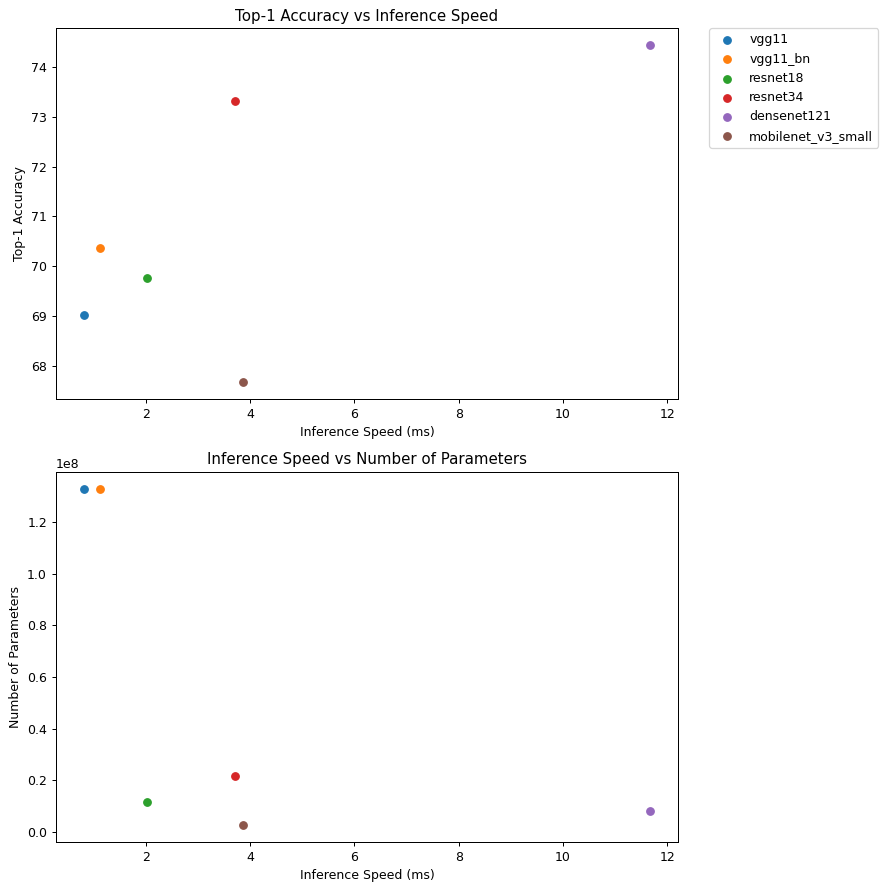

In [43]:
plt.figure(figsize=(10, 10), dpi=90, tight_layout=True)

plt.subplot(2, 1, 1)
plt.xlabel("Inference Speed (ms)")
plt.ylabel("Top-1 Accuracy")
plt.title("Top-1 Accuracy vs Inference Speed")

for i in range(len(model)):
    plt.scatter(inference_speeds[i], top_1_accuracy[i], label=model[i][1])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.subplot(2, 1, 2)
plt.xlabel("Inference Speed (ms)")
plt.ylabel("Number of Parameters")
plt.title("Inference Speed vs Number of Parameters")
for i in range(len(model)):
    plt.scatter(inference_speeds[i], num_parameters[i], label=model[i][1])


plt.show()

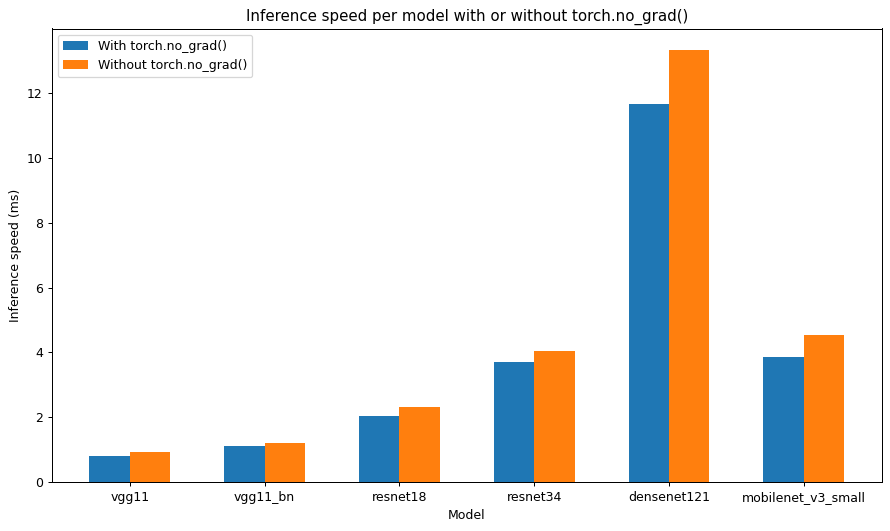

In [47]:
plt.figure(figsize=(10, 6), dpi=90, tight_layout=True)

#plt.subplot(2, 1, 1)
plt.xlabel("Model")
plt.ylabel("Inference speed (ms)")
plt.title("Inference speed per model with or without torch.no_grad()")
plt.bar([x for x in range(len(model))], inference_speeds, width=0.3, label="With torch.no_grad()")
plt.bar([x+0.3 for x in range(len(model))], inference_speeds_grad, width=0.3, label="Without torch.no_grad()")
plt.xticks([x+0.15 for x in range(len(model))], [m[1] for m in model])
plt.legend()
plt.show()

In [ ]:
# For the same models as in (a), 
# plot the amount of GPU vRAM (you can check this with code by 
# executing torch.cuda.memory_allocated() or with the terminal using 
# nvidia-smi) while conducting a forward pass with torch.no_grad() and without. 
# Does torch.no_grad() influence the memory usage? 
# Why? Make sure to save the output after the forward pass. 
# Use batch_size=64 and report the memory in MB.

In [10]:
def inference_memory(model, device, grad = True):
    model.eval()
    model.to(device)
    if grad:
        mem_in = torch.cuda.memory_allocated(device)
        rand_img = torch.rand(64, 3, 224, 224).to(device)
        output = model(rand_img)
        mem_out = torch.cuda.memory_allocated(device)
    else:
        with torch.no_grad():
            mem_in = torch.cuda.memory_allocated(device)
            rand_img = torch.rand(64, 3, 224, 224).to(device)
            output = model(rand_img)
            mem_out = torch.cuda.memory_allocated(device)
    torch.cuda.empty_cache()
    return (mem_out - mem_in) / (1024 * 1024) 




In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
inference_memorys = [inference_memory(m, device) for m, _ in model]

In [29]:
im = inference_memory(model[4][0], device, grad=True)

In [16]:
inference_memorys_no_grad = [inference_memory(m, device, grad=False) for m, _ in model]

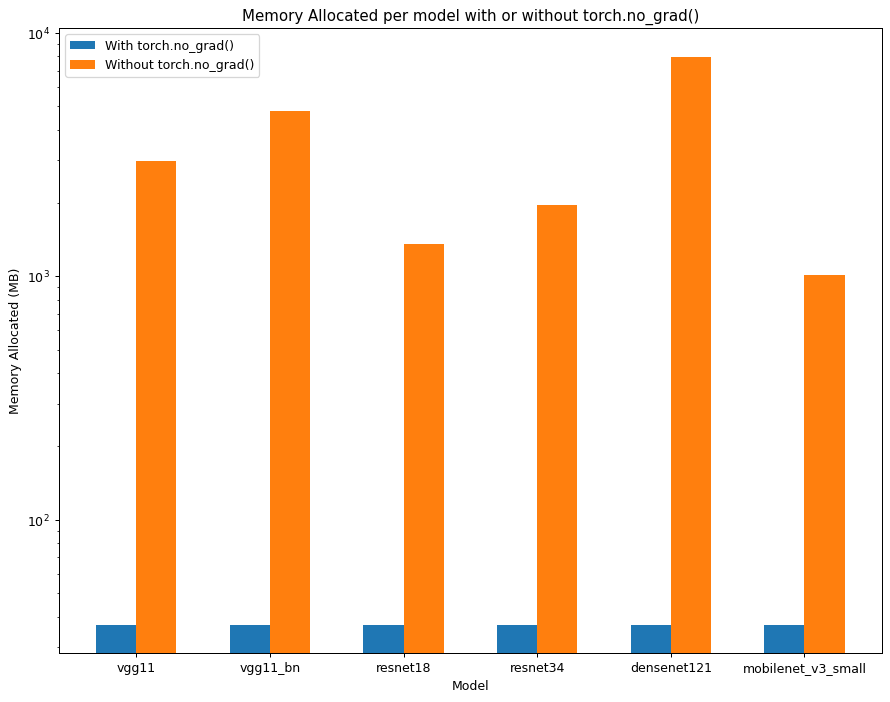

In [58]:
# plot the memory allocated for each model, with and without torch.no_grad()
# Use a bar plot with two bars next to each other for each model, one for with torch.no_grad() and one for without.

plt.figure(figsize=(10, 15), dpi=90, tight_layout=True)

plt.subplot(2, 1, 1)
plt.xlabel("Model")
plt.ylabel("Memory Allocated (MB)")
plt.title("Memory Allocated per model with or without torch.no_grad()")
plt.bar([x for x in range(len(model))], inference_memorys_no_grad, width=0.3, label="With torch.no_grad()")
plt.bar([x+0.3 for x in range(len(model))], inference_memorys, width=0.3, label="Without torch.no_grad()")
plt.yscale("log")
plt.xticks([x+0.15 for x in range(len(model))], [m[1] for m in model])
plt.legend()

plt.show()





In [6]:
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
resnet18.fc = nn.Linear(512, 1000)

NameError: name 'nn' is not defined